# Workshop 9 - Introduction to Convolutional Neural Networks

Code for workshop 9.  This will use Keras (within tensorflow v2) to build a small CNN

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os, time
import pandas as pd

# Deep Learning imports
import tensorflow as tf
from tensorflow import keras

# To plot nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns; sns.set()

In [2]:
# Check the versions are OK (both should be 2 or more)
print(tf.__version__)
print(keras.__version__)

2.8.0
2.8.0


## Load data
We will use MNIST, which is a set of small images (28x28) that contain 10 different fashion items - see below for class names and an example image.

In [3]:
# This is a built-in data for keras, so easily accessible
mnist = keras.datasets.mnist
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

In [4]:
# Let's see how big it is
print(X_train_full.shape)
print(X_test.shape)
n_total = X_train_full.shape[0]

(60000, 28, 28)
(10000, 28, 28)


float64
float64
7


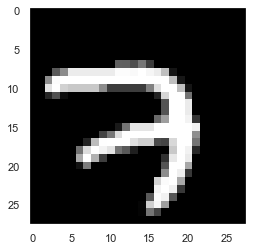

In [5]:
# Scale the data appropriately (it starts with max of 255, but we want max of 1)
# We will do this "by hand" here, but we could build a pipeline scaler for this instead
# We also split the training set given to us into training and validation subsets
#   The value of 5000 samples as the size of the validation set is an arbitrary choice
X_test = X_test/255.0
X_val, X_train = X_train_full[:5000]/255.0, X_train_full[5000:]/255.0 
y_val, y_train = y_train_full[:5000], y_train_full[5000:]
class_names = np.array([ "0","1","2","3","4","5","6","7","8","9" ])

# Inspect some aspects of the data (in general, you should play around with the data 
#                                   more than this to get a feel for it)
# Check that scaled types are appropriate
print(X_train.dtype)
print(X_val.dtype)
# Look at first item
print(class_names[y_train[0]])
plt.imshow(X_train[0,:,:], cmap='gray')
plt.grid(False)
plt.show()

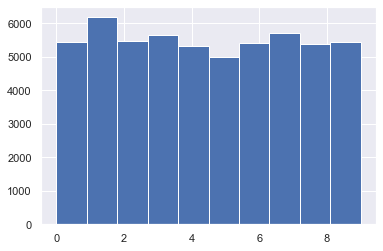

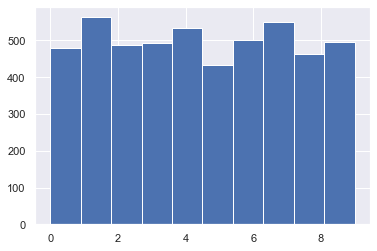

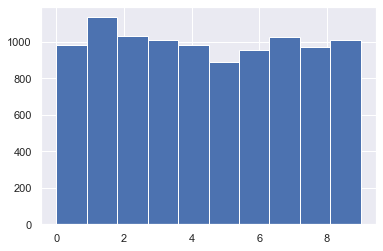

In [6]:
# Let's look at the distribution of labels in the training, validation and test sets
plt.hist(y_train)
plt.show()
plt.hist(y_val)
plt.show()
plt.hist(y_test)
plt.show()

## Simple Neural Network Code with Keras

We will use the keras version built into tensorflow version 2.
It is remarkably simple for building, training and evaluating networks.

In [7]:
# Some key parameters
n_train = 3000
n_val = 1000
# Define the number and size of hidden layers
hiddensizes = [16, 32, 16]
# Define the activation function to be used by hidden layers
actfn = "relu"
# Optimiser and learning rate
optimizer = keras.optimizers.SGD
learningrate = 0.01   # SGD default value
# Set size of batch and number of epochs
batch_size = 32
n_epochs = 20

In [9]:
# Build a CNN
def model_cnn_factory(hiddensizes, actfn, optimizer, learningrate):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(filters=hiddensizes[0], kernel_size=3, strides=1, activation=actfn, padding="same", 
                                  input_shape=[28, 28, 1]))    # input layer goes into this 2D convolution
    model.add(keras.layers.MaxPooling2D(pool_size=2))          # Pool (downsize)
    for n in hiddensizes[1:-1]:
        model.add(keras.layers.Conv2D(filters=n, kernel_size=3, strides=1, padding="same", activation=actfn))  # 2nd Conv
        model.add(keras.layers.MaxPooling2D(pool_size=2))          # Pool (downsize)
    model.add(keras.layers.Conv2D(filters=hiddensizes[-1], kernel_size=3, strides=1, padding="same", activation=actfn))  # 2nd Conv
    model.add(keras.layers.Flatten())                          # unravel into a 1D vector
    model.add(keras.layers.Dense(10, activation = "softmax"))  # always have 10 classes
    model.???(loss="sparse_categorical_crossentropy", optimizer=optimizer(learning_rate=learningrate), metrics=["accuracy"])   
    return model

In [10]:
# Reshape the data to be shape [Nx, Ny, 1]  (previously 2D was fine, but for CNN we need depth too)
X_train = X_train.reshape((-1, 28, 28, 1))
X_val = X_val.reshape((-1, 28, 28, 1))
X_test = X_test.reshape((-1, 28, 28, 1))

In [11]:
# Early stopping callback - this is executed when fitting and will stop and restore best result
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True) 

In [12]:
def do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_val, n_epochs, batch_size):
    model = model_cnn_factory(hiddensizes, actfn, optimizer, learningrate)
    history = model.???(X_train[:n_train,:,:,:], y_train[:n_train], epochs=n_epochs, callbacks = [early_stopping_cb],
                        validation_data=(X_val[:n_val,:,:,:], y_val[:n_val]))
    max_val_acc = np.max(history.history['val_accuracy'])
    return (max_val_acc, history, model)

In [13]:
valacc, history, model = do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_val, n_epochs, batch_size)

2022-05-27 18:47:39.591554: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
94/94 [==============================] - 1s 10ms/step - loss: 2.2527 - accuracy: 0.2910 - val_loss: 2.1875 - val_accuracy: 0.4050
Epoch 2/20
94/94 [==============================] - 1s 9ms/step - loss: 1.9510 - accuracy: 0.4883 - val_loss: 1.5115 - val_accuracy: 0.6390
Epoch 3/20
94/94 [==============================] - 1s 10ms/step - loss: 1.0255 - accuracy: 0.7007 - val_loss: 0.7746 - val_accuracy: 0.7580
Epoch 4/20
94/94 [==============================] - 1s 9ms/step - loss: 0.6173 - accuracy: 0.8067 - val_loss: 0.6591 - val_accuracy: 0.7800
Epoch 5/20
94/94 [==============================] - 1s 9ms/step - loss: 0.4874 - accuracy: 0.8497 - val_loss: 0.6507 - val_accuracy: 0.8030
Epoch 6/20
94/94 [==============================] - 1s 9ms/step - loss: 0.4093 - accuracy: 0.8693 - val_loss: 0.4781 - val_accuracy: 0.8660
Epoch 7/20
94/94 [==============================] - 1s 9ms/step - loss: 0.3786 - accuracy: 0.8840 - val_loss: 0.4194 - val_accuracy: 0.8790
Epoch 8/20
94/94 [

In [14]:
def plot_history(history):
    # Plot the results (shifting validation curves appropriately)
    plt.figure(figsize=(8,5))
    n = len(history.history['accuracy'])
    plt.plot(np.arange(0,n),history.history['accuracy'], color='orange')
    plt.plot(np.arange(0,n),history.history['loss'],'b')
    plt.plot(np.arange(0,n)+0.5,history.history['val_accuracy'],'r')  # offset both validation curves
    plt.plot(np.arange(0,n)+0.5,history.history['val_loss'],'g')
    plt.legend(['Train Acc','Train Loss','Val Acc','Val Loss'])
    plt.grid(True)
    plt.gca().set_ylim(0, 1) # set the vertical range to [0-1] 
    plt.show() 

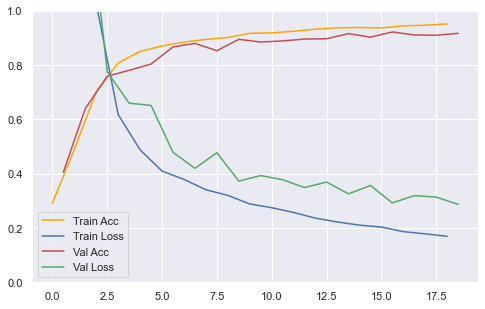

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 16)          4624      
                                                                 
 flatten (Flatten)           (None, 784)               0

In [15]:
plot_history(history)
model.summary()

[1 0 0 0 2 0 2 0 0 2]
['1' '0' '0' '0' '2' '0' '2' '0' '0' '2']
['5' '0' '4']


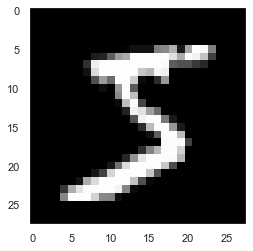

In [16]:
# We can inspect the output class predictions
y_pred = np.argmax(model.predict(X_val[:3]),axis=0)  # use the first three val cases as an example
print(y_pred)   # predicted classes
print(class_names[y_pred])   # names of these classes (prediction)
print(class_names[y_val[:3]])   # names of true classes
# Display an image of the first val sample
plt.imshow(X_val[0].reshape((28,28)), cmap="gray")
plt.grid(False)

In [17]:
# Now run the model on the val set and get results (loss and accuracy both reported)
valres = model.evaluate(X_val, y_val, verbose=0)
print(valres)

[0.2570890486240387, 0.9243999719619751]


In [18]:
# We can also look at the probability of predicting each class rather than the class with max probability
# Each row has ten probabilities (one per class)
y_proba = model.predict(X_val[:3])
print(y_proba.round(2))  # round to two decimal places when printing

[[0.   0.   0.01 0.61 0.   0.37 0.   0.   0.   0.  ]
 [1.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.02 0.97 0.   0.   0.   0.   0.01]]


# Exploring parameters

For example, why make these particular choices for architecture and parameters.

Let us systematically vary one parameter at a time.

Learning Rate = 100
Epoch 1/20
94/94 [==============================] - 1s 10ms/step - loss: 2.3381 - accuracy: 0.1083 - val_loss: 2.3090 - val_accuracy: 0.1000
Epoch 2/20
94/94 [==============================] - 1s 9ms/step - loss: 2.3078 - accuracy: 0.1097 - val_loss: 2.3173 - val_accuracy: 0.1000
Epoch 3/20
94/94 [==============================] - 1s 9ms/step - loss: 2.3095 - accuracy: 0.0983 - val_loss: 2.3097 - val_accuracy: 0.0990
Epoch 4/20
94/94 [==============================] - 1s 9ms/step - loss: 2.3086 - accuracy: 0.1053 - val_loss: 2.3112 - val_accuracy: 0.1160
Epoch 5/20
94/94 [==============================] - 1s 9ms/step - loss: 2.3092 - accuracy: 0.0970 - val_loss: 2.3076 - val_accuracy: 0.0930
Epoch 6/20
94/94 [==============================] - 1s 9ms/step - loss: 2.3077 - accuracy: 0.1010 - val_loss: 2.3187 - val_accuracy: 0.0930
Epoch 7/20
94/94 [==============================] - 1s 9ms/step - loss: 2.3100 - accuracy: 0.1017 - val_loss: 2.3095 - val_accuracy: 0.0930

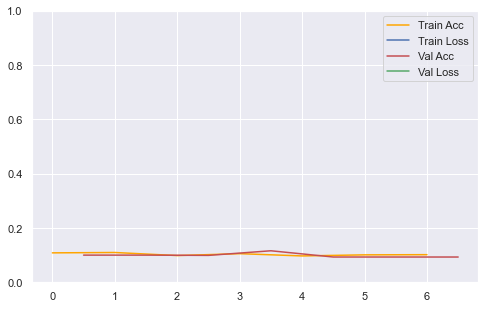

Learning Rate = 10
Epoch 1/20
94/94 [==============================] - 1s 10ms/step - loss: 1.1193 - accuracy: 0.6407 - val_loss: 0.3625 - val_accuracy: 0.8920
Epoch 2/20
94/94 [==============================] - 1s 9ms/step - loss: 0.2920 - accuracy: 0.9097 - val_loss: 0.3119 - val_accuracy: 0.8970
Epoch 3/20
94/94 [==============================] - 1s 9ms/step - loss: 0.2154 - accuracy: 0.9340 - val_loss: 0.2237 - val_accuracy: 0.9360
Epoch 4/20
94/94 [==============================] - 1s 9ms/step - loss: 0.1528 - accuracy: 0.9513 - val_loss: 0.2333 - val_accuracy: 0.9380
Epoch 5/20
94/94 [==============================] - 1s 9ms/step - loss: 0.1294 - accuracy: 0.9583 - val_loss: 0.1924 - val_accuracy: 0.9510
Epoch 6/20
94/94 [==============================] - 1s 9ms/step - loss: 0.1095 - accuracy: 0.9640 - val_loss: 0.2028 - val_accuracy: 0.9520
Epoch 7/20
94/94 [==============================] - 1s 9ms/step - loss: 0.0796 - accuracy: 0.9737 - val_loss: 0.2076 - val_accuracy: 0.9500


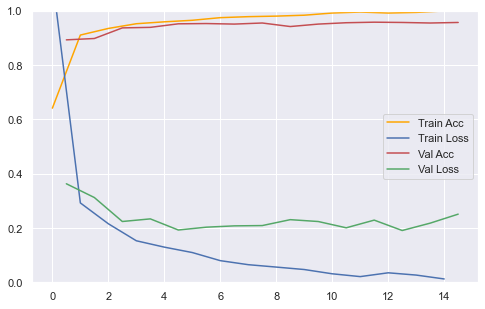

Learning Rate = 1
Epoch 1/20
94/94 [==============================] - 1s 10ms/step - loss: 2.2830 - accuracy: 0.2090 - val_loss: 2.2581 - val_accuracy: 0.3020
Epoch 2/20
94/94 [==============================] - 1s 10ms/step - loss: 2.1965 - accuracy: 0.3350 - val_loss: 2.1013 - val_accuracy: 0.4240
Epoch 3/20
94/94 [==============================] - 1s 9ms/step - loss: 1.7717 - accuracy: 0.5410 - val_loss: 1.3211 - val_accuracy: 0.5850
Epoch 4/20
94/94 [==============================] - 1s 10ms/step - loss: 0.8970 - accuracy: 0.7347 - val_loss: 0.6449 - val_accuracy: 0.8120
Epoch 5/20
94/94 [==============================] - 1s 9ms/step - loss: 0.5715 - accuracy: 0.8203 - val_loss: 0.5773 - val_accuracy: 0.8260
Epoch 6/20
94/94 [==============================] - 1s 9ms/step - loss: 0.4623 - accuracy: 0.8527 - val_loss: 0.4866 - val_accuracy: 0.8540
Epoch 7/20
94/94 [==============================] - 1s 9ms/step - loss: 0.4015 - accuracy: 0.8753 - val_loss: 0.4136 - val_accuracy: 0.8800

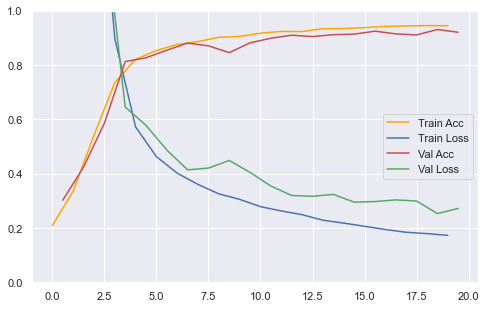

Learning Rate = 0.1
Epoch 1/20
94/94 [==============================] - 1s 10ms/step - loss: 2.3242 - accuracy: 0.0833 - val_loss: 2.3125 - val_accuracy: 0.1030
Epoch 2/20
94/94 [==============================] - 1s 9ms/step - loss: 2.3097 - accuracy: 0.0940 - val_loss: 2.3023 - val_accuracy: 0.1120
Epoch 3/20
94/94 [==============================] - 1s 10ms/step - loss: 2.2982 - accuracy: 0.1010 - val_loss: 2.2935 - val_accuracy: 0.1240
Epoch 4/20
94/94 [==============================] - 1s 9ms/step - loss: 2.2882 - accuracy: 0.1213 - val_loss: 2.2853 - val_accuracy: 0.1390
Epoch 5/20
94/94 [==============================] - 1s 9ms/step - loss: 2.2787 - accuracy: 0.1510 - val_loss: 2.2772 - val_accuracy: 0.1660
Epoch 6/20
94/94 [==============================] - 1s 9ms/step - loss: 2.2693 - accuracy: 0.1817 - val_loss: 2.2690 - val_accuracy: 0.1940
Epoch 7/20
94/94 [==============================] - 1s 9ms/step - loss: 2.2597 - accuracy: 0.2227 - val_loss: 2.2605 - val_accuracy: 0.207

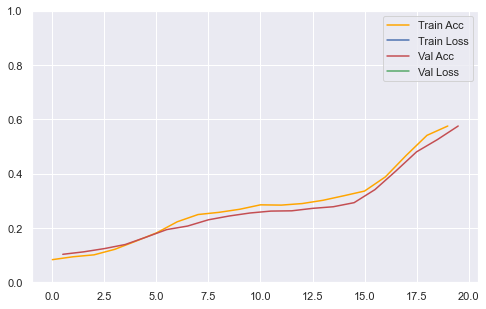

[[1.0, 0.11599999666213989], [0.1, 0.9570000171661377], [0.01, 0.9300000071525574], [0.001, 0.574999988079071]]


In [19]:
# Learning rate
res=[]
for lr in [100, 10, 1, 0.1]:
    print(f'Learning Rate = {lr}')
    valacc, history, model = do_all(hiddensizes, actfn, optimizer, lr*learningrate, n_train, n_val, n_epochs, batch_size)
    plot_history(history)
    res += [[lr*learningrate,valacc]]
print(res)

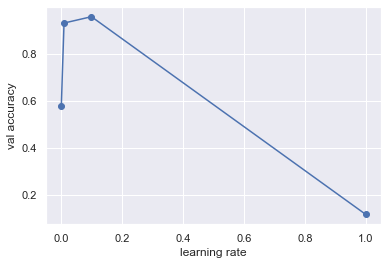

In [20]:
# Plot results (val accuracy vs factor that is changing)
res=np.array(res)
plt.plot(res[:,???],res[:,???],'-o')
plt.xlabel('learning rate')
plt.ylabel('val accuracy')
plt.show()

## Comment
This shows a dramatic decrease in performance at the highest learning rate, and the learning curve corresponding to that (first plot in this group) clearly shows that it is not learning at all.

The lowest learning rate could definitely have got better performance if more epochs were run, but is clearly out competed by the middle two learning rates, which is most clearly seen in the learning curve plots. In the curve for the learning rate of 10 it clearly learns extremely quickly, which is very good, although fast learning can be associated with instabilities, but that does not seem to be the case here. Hence this learning rate is clearly a lot better, not just because of the final performance, but also due to the speed of learning.  

Remember that all of this is only true for the particular architecture and dataset used, and if either is changed, then the optimal learning rate can change too.  So this type of optimisation needs to be done a lot, and there are ways of automating it, such as the one-cycle scheme, with an early phase that sweeps along a large range of learning rates to see when the performance starts rapidly changing. 

Number of Layers = 1
Epoch 1/20
94/94 [==============================] - 1s 8ms/step - loss: 1.9182 - accuracy: 0.4940 - val_loss: 1.1642 - val_accuracy: 0.7400
Epoch 2/20
94/94 [==============================] - 1s 7ms/step - loss: 0.7334 - accuracy: 0.7993 - val_loss: 0.5306 - val_accuracy: 0.8550
Epoch 3/20
94/94 [==============================] - 1s 7ms/step - loss: 0.4799 - accuracy: 0.8460 - val_loss: 0.5308 - val_accuracy: 0.8400
Epoch 4/20
94/94 [==============================] - 1s 7ms/step - loss: 0.4246 - accuracy: 0.8653 - val_loss: 0.4574 - val_accuracy: 0.8640
Epoch 5/20
94/94 [==============================] - 1s 7ms/step - loss: 0.3814 - accuracy: 0.8900 - val_loss: 0.4289 - val_accuracy: 0.8800
Epoch 6/20
94/94 [==============================] - 1s 7ms/step - loss: 0.3631 - accuracy: 0.8890 - val_loss: 0.4290 - val_accuracy: 0.8880
Epoch 7/20
94/94 [==============================] - 1s 7ms/step - loss: 0.3442 - accuracy: 0.8977 - val_loss: 0.4454 - val_accuracy: 0.8720

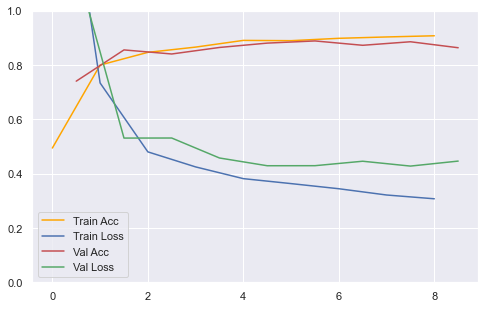

Number of Layers = 2
Epoch 1/20
94/94 [==============================] - 1s 9ms/step - loss: 2.0866 - accuracy: 0.4457 - val_loss: 1.6085 - val_accuracy: 0.6670
Epoch 2/20
94/94 [==============================] - 1s 7ms/step - loss: 0.9100 - accuracy: 0.7763 - val_loss: 0.6159 - val_accuracy: 0.8030
Epoch 3/20
94/94 [==============================] - 1s 7ms/step - loss: 0.4919 - accuracy: 0.8447 - val_loss: 0.4700 - val_accuracy: 0.8710
Epoch 4/20
94/94 [==============================] - 1s 7ms/step - loss: 0.4056 - accuracy: 0.8777 - val_loss: 0.4429 - val_accuracy: 0.8720
Epoch 5/20
94/94 [==============================] - 1s 7ms/step - loss: 0.3642 - accuracy: 0.8977 - val_loss: 0.4065 - val_accuracy: 0.8820
Epoch 6/20
94/94 [==============================] - 1s 7ms/step - loss: 0.3415 - accuracy: 0.9000 - val_loss: 0.4507 - val_accuracy: 0.8650
Epoch 7/20
94/94 [==============================] - 1s 7ms/step - loss: 0.3216 - accuracy: 0.9057 - val_loss: 0.4207 - val_accuracy: 0.8860

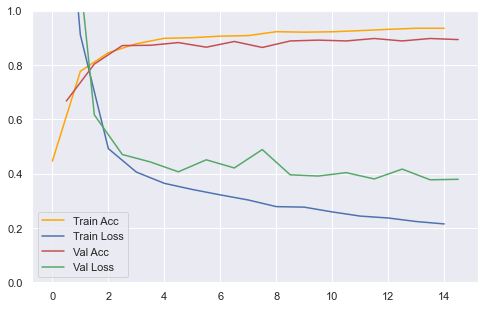

Number of Layers = 3
Epoch 1/20
94/94 [==============================] - 2s 14ms/step - loss: 2.2797 - accuracy: 0.1130 - val_loss: 2.2447 - val_accuracy: 0.1850
Epoch 2/20
94/94 [==============================] - 1s 11ms/step - loss: 2.1636 - accuracy: 0.2983 - val_loss: 2.0377 - val_accuracy: 0.4430
Epoch 3/20
94/94 [==============================] - 1s 11ms/step - loss: 1.5741 - accuracy: 0.6067 - val_loss: 1.1027 - val_accuracy: 0.6540
Epoch 4/20
94/94 [==============================] - 1s 11ms/step - loss: 0.8280 - accuracy: 0.7510 - val_loss: 0.6222 - val_accuracy: 0.8050
Epoch 5/20
94/94 [==============================] - 1s 12ms/step - loss: 0.5757 - accuracy: 0.8173 - val_loss: 0.5547 - val_accuracy: 0.8200
Epoch 6/20
94/94 [==============================] - 1s 12ms/step - loss: 0.4570 - accuracy: 0.8570 - val_loss: 0.4692 - val_accuracy: 0.8620
Epoch 7/20
94/94 [==============================] - 1s 12ms/step - loss: 0.4071 - accuracy: 0.8733 - val_loss: 0.4792 - val_accuracy:

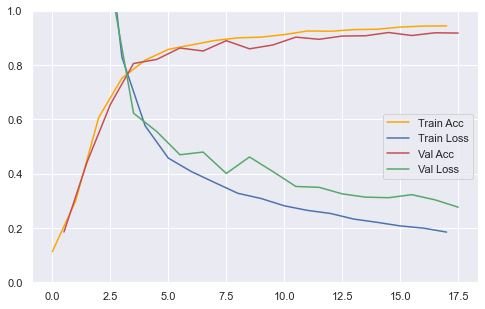

[[1, 0.8880000114440918], [2, 0.8970000147819519], [3, 0.9190000295639038]]


In [21]:
# Number of layers
res=[]
for n in [1, 2, 3]:
    print(f'Number of Layers = {n}')
    valacc, history, model = do_all(hiddensizes[:n], actfn, optimizer, learningrate, n_train, n_val, n_epochs, batch_size)
    plot_history(history)
    res += [[n,valacc]]
print(res)

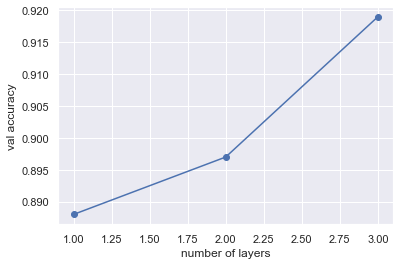

In [22]:
# Plot results (val accuracy vs factor that is changing)
res=np.array(res)
plt.plot(res[:,???],res[:,???],'-o')
plt.xlabel('number of layers')
plt.ylabel('val accuracy')
plt.show()

## Comment
This shows a steady increase with the number of layers, but note that the range of accuracy on the y-axis is quite small. Running for more epochs, especially for the case with 3 layers is likely to do even better (but is not shown on a graph like this - only in the learning curves).

Training Set Size = 30.0
Epoch 1/20
1/1 [==============================] - 1s 897ms/step - loss: 2.3336 - accuracy: 0.0333 - val_loss: 2.3043 - val_accuracy: 0.0670
Epoch 2/20
1/1 [==============================] - 0s 184ms/step - loss: 2.3291 - accuracy: 0.0333 - val_loss: 2.3030 - val_accuracy: 0.0680
Epoch 3/20
1/1 [==============================] - 0s 225ms/step - loss: 2.3248 - accuracy: 0.0333 - val_loss: 2.3018 - val_accuracy: 0.0690
Epoch 4/20
1/1 [==============================] - 0s 230ms/step - loss: 2.3205 - accuracy: 0.0333 - val_loss: 2.3006 - val_accuracy: 0.0700
Epoch 5/20
1/1 [==============================] - 0s 220ms/step - loss: 2.3163 - accuracy: 0.0333 - val_loss: 2.2995 - val_accuracy: 0.0700
Epoch 6/20
1/1 [==============================] - 0s 214ms/step - loss: 2.3124 - accuracy: 0.0333 - val_loss: 2.2984 - val_accuracy: 0.0750
Epoch 7/20
1/1 [==============================] - 0s 179ms/step - loss: 2.3085 - accuracy: 0.0333 - val_loss: 2.2974 - val_accuracy: 0.

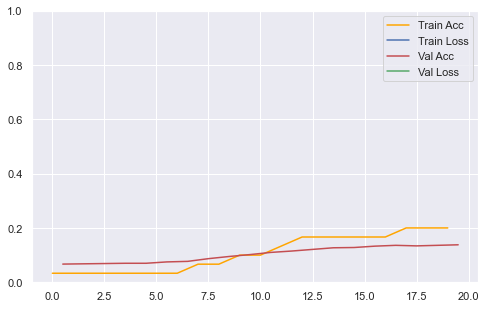

Training Set Size = 300.0
Epoch 1/20
10/10 [==============================] - 1s 52ms/step - loss: 2.2899 - accuracy: 0.1433 - val_loss: 2.2958 - val_accuracy: 0.1130
Epoch 2/20
10/10 [==============================] - 0s 31ms/step - loss: 2.2830 - accuracy: 0.1500 - val_loss: 2.2910 - val_accuracy: 0.1110
Epoch 3/20
10/10 [==============================] - 0s 31ms/step - loss: 2.2760 - accuracy: 0.1433 - val_loss: 2.2861 - val_accuracy: 0.1150
Epoch 4/20
10/10 [==============================] - 0s 29ms/step - loss: 2.2684 - accuracy: 0.1433 - val_loss: 2.2811 - val_accuracy: 0.1140
Epoch 5/20
10/10 [==============================] - 0s 30ms/step - loss: 2.2610 - accuracy: 0.1433 - val_loss: 2.2756 - val_accuracy: 0.1140
Epoch 6/20
10/10 [==============================] - 0s 30ms/step - loss: 2.2529 - accuracy: 0.1467 - val_loss: 2.2700 - val_accuracy: 0.1150


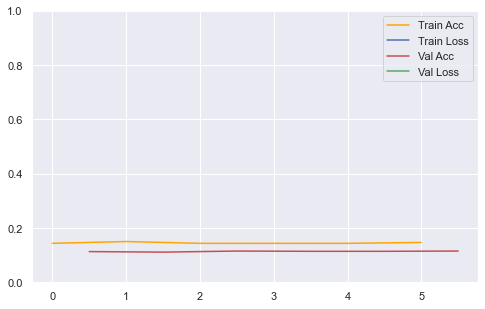

Training Set Size = 1500.0
Epoch 1/20
47/47 [==============================] - 1s 20ms/step - loss: 2.2948 - accuracy: 0.1020 - val_loss: 2.2720 - val_accuracy: 0.1840
Epoch 2/20
47/47 [==============================] - 1s 15ms/step - loss: 2.2478 - accuracy: 0.2407 - val_loss: 2.2251 - val_accuracy: 0.2740
Epoch 3/20
47/47 [==============================] - 1s 16ms/step - loss: 2.1738 - accuracy: 0.3187 - val_loss: 2.1246 - val_accuracy: 0.3370
Epoch 4/20
47/47 [==============================] - 1s 15ms/step - loss: 1.9849 - accuracy: 0.4587 - val_loss: 1.8168 - val_accuracy: 0.6160
Epoch 5/20
47/47 [==============================] - 1s 16ms/step - loss: 1.4536 - accuracy: 0.6540 - val_loss: 1.1462 - val_accuracy: 0.7030
Epoch 6/20
47/47 [==============================] - 1s 15ms/step - loss: 0.8886 - accuracy: 0.7433 - val_loss: 0.8877 - val_accuracy: 0.7270
Epoch 7/20
47/47 [==============================] - 1s 18ms/step - loss: 0.6914 - accuracy: 0.7947 - val_loss: 0.6634 - val_acc

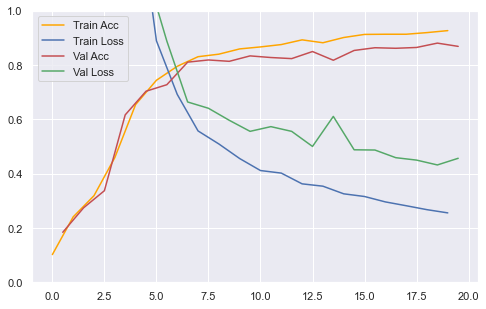

Training Set Size = 3000
Epoch 1/20
94/94 [==============================] - 2s 14ms/step - loss: 2.2911 - accuracy: 0.1890 - val_loss: 2.2761 - val_accuracy: 0.2470
Epoch 2/20
94/94 [==============================] - 1s 12ms/step - loss: 2.2447 - accuracy: 0.3317 - val_loss: 2.2099 - val_accuracy: 0.3810
Epoch 3/20
94/94 [==============================] - 1s 13ms/step - loss: 2.0645 - accuracy: 0.4733 - val_loss: 1.8194 - val_accuracy: 0.5580
Epoch 4/20
94/94 [==============================] - 1s 13ms/step - loss: 1.2207 - accuracy: 0.6813 - val_loss: 0.8462 - val_accuracy: 0.7430
Epoch 5/20
94/94 [==============================] - 1s 11ms/step - loss: 0.6627 - accuracy: 0.7880 - val_loss: 0.6421 - val_accuracy: 0.8040
Epoch 6/20
94/94 [==============================] - 1s 11ms/step - loss: 0.5255 - accuracy: 0.8353 - val_loss: 0.5379 - val_accuracy: 0.8400
Epoch 7/20
94/94 [==============================] - 1s 12ms/step - loss: 0.4331 - accuracy: 0.8623 - val_loss: 0.8435 - val_accur

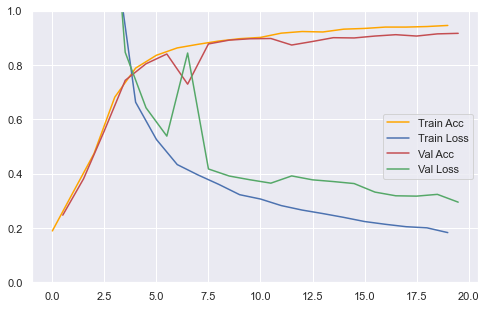

[[30, 0.1379999965429306], [300, 0.11500000208616257], [1500, 0.8799999952316284], [3000, 0.9160000085830688]]


In [23]:
# Training set size
res=[]
for ntr in [n_train*0.01, n_train*0.1, n_train*0.5, n_train]:
    print(f'Training Set Size = {ntr}')
    valacc, history, model = do_all(hiddensizes, actfn, optimizer, learningrate, int(ntr), n_val, n_epochs, batch_size)
    plot_history(history)
    res += [[int(ntr),valacc]]
print(res)

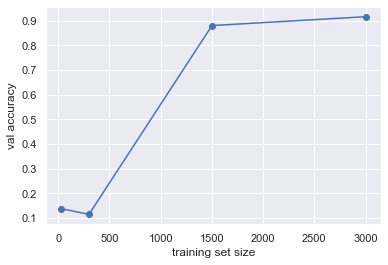

In [24]:
# Plot results (val accuracy vs factor that is changing)
res=np.array(res)
plt.plot(res[:,???],res[:,???],'-o')
plt.xlabel('training set size')
plt.ylabel('val accuracy')
plt.show()

## Comments
Note how big the increase is here, as it is clearly failing (the extreme end of underfitting) with a small training set size, but doing very well from 1500 and higher. It is unclear from this what you might expect for a size of 1000, as it could be in the middle, or very similar to the low or high ends.

Also note that this does not tell you how rapidly it is learning, whether it would have continued to do better with more epochs, or whether it is unstable. To know about these things it is crucially important to see the learning curves. This is why it is dangerous to only look at outputs like this graph, or even less in the case of automated hyperparameter tuning methods, as they might give you a network that happened to do well on the validation set for just one epoch and was in general very unstable. Such a network is very unlikely to do well in practice on new, unseen data.